#### Import library
- tensorflow
- layers
- models
- ImageDataGenerator

In [44]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
import pickle
import keras
from keras import ops
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

##### prepare data for training and testing

In [74]:
# Define your categories
CATEGORIES = ["enjoying", "studying"]
CATEGORIESDIR = "D:\Github\Activity.tracking_model\dataset"
IMG_SIZE = 224
training_data = []

for category in CATEGORIES:
    path = os.path.join(CATEGORIESDIR, category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([new_array, class_num])
        except Exception as e:
            pass
# Shuffle the training data
np.random.shuffle(training_data)


# Separate features and labels
x = []
y = []

for features, label in training_data:
    x.append(features)
    y.append(label)

# Convert lists to numpy arrays
x = np.array(x).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array(y).reshape(-1, 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Print the shapes of the arrays
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (320, 224, 224, 3) - y_train shape: (320, 1)
x_test shape: (80, 224, 224, 3) - y_test shape: (80, 1)


##### Use data augmentation

In [78]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization()
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

#### Configure Hyperparameters

In [82]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 30
image_size = 224
patch_size = 32
num_patches = (image_size // patch_size) ** 2

num_classes = len(CATEGORIES)
input_shape = (224, 224, 3)

projection_dim = 64
num_heads = 4
transformer_units = {
    projection_dim * 2,
    projection_dim,
}

transformer_layers = 8
mlp_head_units = [2048, 1024]


##### Implement multilayer perceptron (MLP)

In [83]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

##### Implement patch creation as a layer

In [84]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config

##### Let's display patches for a sample image

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072


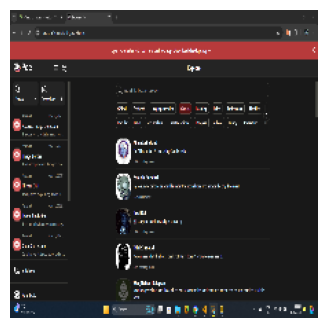

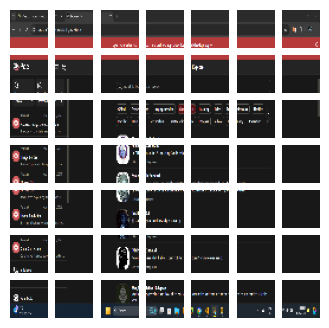

In [85]:
plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

##### Implement the patch encoding layer
The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [86]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

##### Build the ViT model

In [87]:
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches) # 1
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1 # 2
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches]) # 3
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2) # 4
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1) # 5, 6
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2]) # 7

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

##### print parameters of this model

In [92]:
def print_model_parameters(model):
    print("Model Summary:")
    print(model.summary())

# Assuming `vit_classifier` is the VIT model
vit_classifier = create_vit_classifier()
print_model_parameters(vit_classifier)

Model Summary:


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          7 │ input_layer_8[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_12          │ (None, 49, 3072)  │          0 │ data_augmentatio… │
│ (Patches)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_7     │ (None, 49, 64)    │    199,808 │ patches_12[0][0]  │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ patch_encoder_7[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_80 (Add)        │ (None, 49, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_80[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_103 (Dense)   │ (None, 49, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_136         │ (None, 49, 128)   │          0 │ dense_103[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_104 (Dense)   │ (None, 49, 64)    │      8,256 │ dropout_136[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_137         │ (None, 49, 64)    │          0 │ dense_104[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_81 (Add)        │ (None, 49, 64)    │          0 │ dropout_137[0][0… │
│                     │                   │            │ add_80[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_81[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_82 (Add)        │ (None, 49, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_81[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_82[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 9,390,345 (35.82 MB)

 Trainable params: 9,390,338 (35.82 MB)

 Non-trainable params: 7 (32.00 B)

None


##### Compile, train, and evaluate the mode

Epoch 1/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 82s 5s/step - accuracy: 0.3426 - loss: 3.3739 - top-5-accuracy: 1.0000 - val_accuracy: 0.7500 - val_loss: 3.9786 - val_top-5-accuracy: 1.0000
Epoch 2/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.7565 - loss: 4.1344 - top-5-accuracy: 1.0000 - val_accuracy: 0.4688 - val_loss: 3.5955 - val_top-5-accuracy: 1.0000
Epoch 3/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7082 - loss: 1.9202 - top-5-accuracy: 1.0000 - val_accuracy: 0.7812 - val_loss: 1.4701 - val_top-5-accuracy: 1.0000
Epoch 4/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7601 - loss: 1.3742 - top-5-accuracy: 1.0000 - val_accuracy: 0.5312 - val_loss: 1.6148 - val_top-5-accuracy: 1.0000
Epoch 5/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8053 - loss: 0.8756 - top-5-accuracy: 1.0000 - val_accuracy: 0.7500 - val_loss: 1.0083 - val_top-5-accuracy: 1.0000
Epoch 6/30
2/2 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.7862 - loss: 1.2172 - top-5-accuracy: 1.0000 - val_

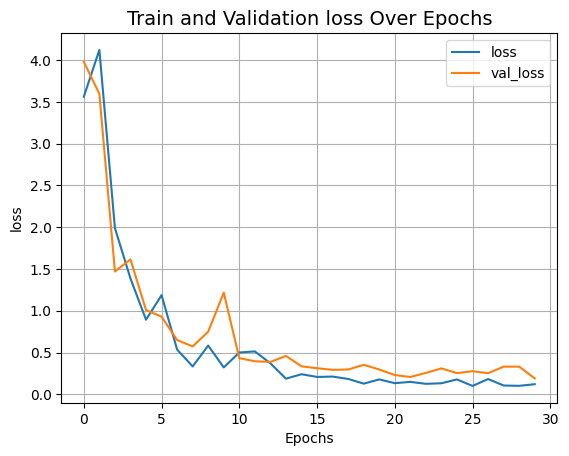

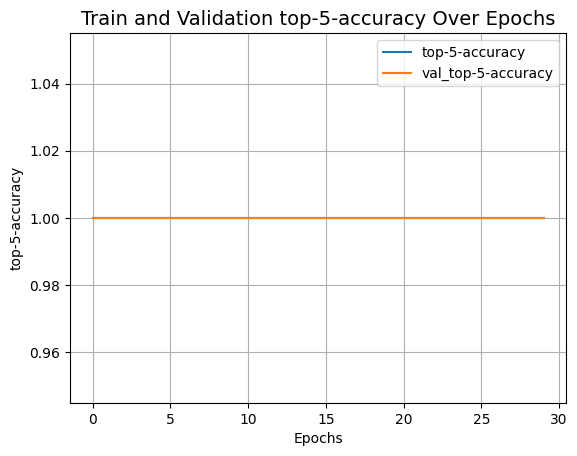

In [88]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")

In [89]:
# Define the path where you want to save the model
model_save_path = "./model/vit_model_v1.h5"

# Save the model
vit_classifier.save(model_save_path)

print("Model saved successfully at:", model_save_path)

Model saved successfully at: ./model/vit_model_v1.h5
